In [1]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# We are taking Acter dataset with the corruption and heart failure domains

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Domain
corp_en_01     983
corp_en_02     403
corp_en_04     261
corp_en_05     247
corp_en_06    1751
corp_en_07    1434
corp_en_08     678
corp_en_09     442
corp_en_10      86
corp_en_11    1039
corp_en_12    1069
corp_en_19     414
Name: Token, dtype: int64


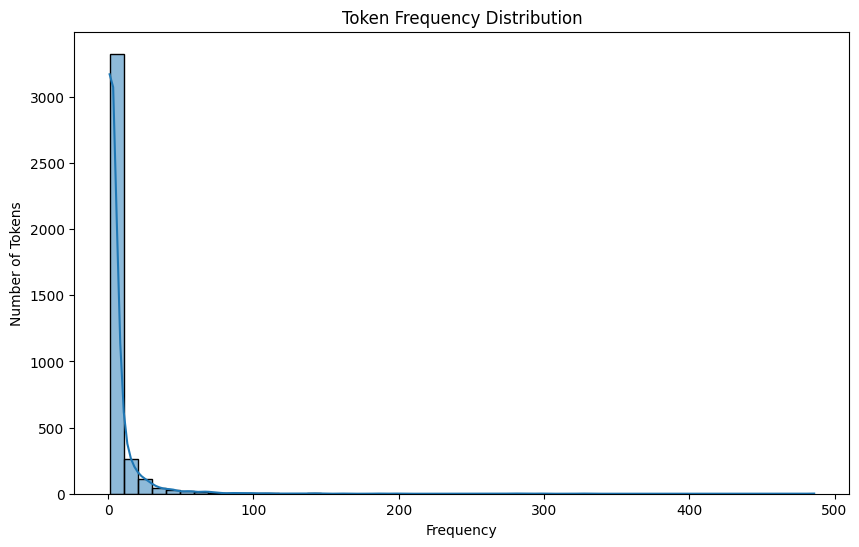

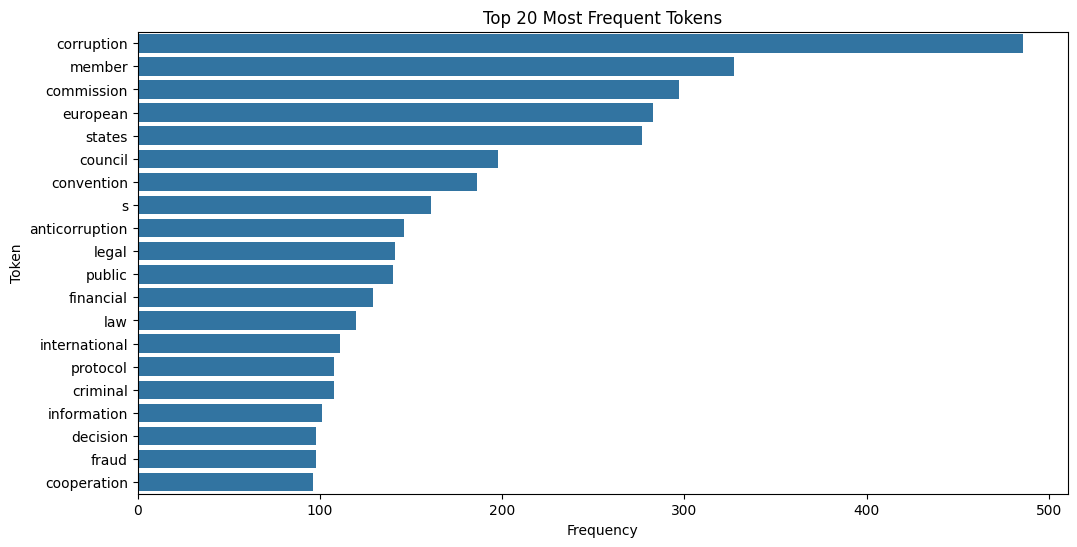

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
import nltk

nltk.download('stopwords')
nltk.download('punkt')


nltk_stopwords = set(stopwords.words('english'))

custom_stopwords = {"the", "of", "and", "a", "with", "to", "in", "on", "be", "for",
                    "as", "eu", "or", "by", "is", "that", "are", "an", "will", "it",
                    "which", "should", "has", "not", "at", "its", "article", "against", "this", "s"
                   ,"may","also","shall","within","greco","1","2"}


stopwords_set = nltk_stopwords.union(custom_stopwords)

data_dir = ""
files = ["corp_en_02.txt", "corp_en_04.txt", "corp_en_01.txt",
         "corp_en_05.txt", "corp_en_06.txt", "corp_en_07.txt", "corp_en_08.txt",
         "corp_en_09.txt", "corp_en_10.txt", "corp_en_11.txt", "corp_en_12.txt", "corp_en_19.txt"]

data_list = []
for file_name in files:
    file_path = os.path.join(data_dir, file_name)

    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()

    tokens = word_tokenize(text)

    filtered_tokens = [re.sub(r'[^\w\s]', '', token).lower()
                       for token in tokens
                       if token.lower() not in stopwords_set and re.sub(r'[^\w\s]', '', token).strip() != '']

    df = pd.DataFrame(filtered_tokens, columns=['Token'])
    df["Domain"] = file_name.split(".")[0]
    data_list.append(df)

full_df = pd.concat(data_list, ignore_index=True)

print(full_df.groupby("Domain")["Token"].nunique())


token_counts = full_df["Token"].value_counts().reset_index()
token_counts.columns = ["Token", "Frequency"]


plt.figure(figsize=(10, 6))
sns.histplot(token_counts['Frequency'], bins=50, kde=True)
plt.title('Token Frequency Distribution')
plt.xlabel('Frequency')
plt.ylabel('Number of Tokens')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x="Frequency", y="Token", data=token_counts.head(20))
plt.title("Top 20 Most Frequent Tokens")
plt.show()


In [5]:
print(token_counts.describe())

         Frequency
count  3846.000000
mean      6.470879
std      17.571864
min       1.000000
25%       1.000000
50%       2.000000
75%       5.000000
max     486.000000


Here are we definen a set of stopwords to be excluded from tokenization.Loop through each file, read its content, tokenize words, remove stopwords, convert tokens into a DataFrame, and append the processed data to a list.Count the frequency of each token and create a DataFrame.Visualize the distribution of token frequencies using a histogram and displaied the top 20 most frequent tokens in the dataset and printed summary statistics.


In [6]:
outliers = token_counts[token_counts['Frequency'] > token_counts['Frequency'].mean() + 3 * token_counts['Frequency'].std()]
print(f'Number of Outlier Tokens: {len(outliers)}')
print('Outlier Tokens:', outliers['Token'].tolist())


Number of Outlier Tokens: 49
Outlier Tokens: ['corruption', 'member', 'commission', 'european', 'states', 'council', 'convention', 's', 'anticorruption', 'legal', 'public', 'financial', 'law', 'international', 'protocol', 'criminal', 'information', 'decision', 'fraud', 'cooperation', 'members', 'report', 'union', 'national', 'person', 'measures', 'rules', 'second', 'would', 'cases', 'participation', 'relevant', 'interests', 'framework', 'protection', 'policy', 'fight', 'state', 'persons', 'countries', 'ecb', '3', 'europe', 'paragraph', 'office', 'political', 'action', 'specific', 'evaluation']


Identified and printed outlier tokens using the 3-sigma rule.

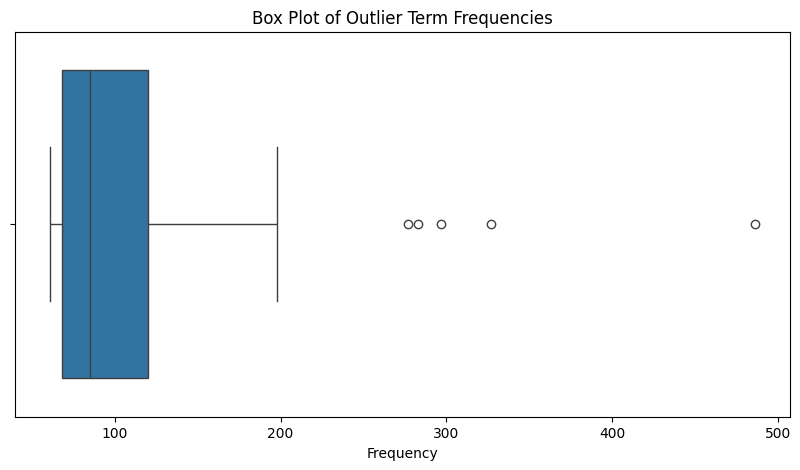

In [7]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=outliers['Frequency'])
plt.title("Box Plot of Outlier Term Frequencies")
plt.xlabel("Frequency")
plt.show()

Visualized outliers in box plot

In [8]:
full_df.drop_duplicates(inplace=True)
full_df.dropna(inplace=True)

In [9]:
token_counts['Normalized_Frequency'] = token_counts['Frequency'] / token_counts['Frequency'].max()

In [10]:
token_counts['Normalized_Frequency']

,Normalized_Frequency
0,1.000000
1,0.672840
2,0.611111
3,0.582305
4,0.569959
...,...
3841,0.002058
3842,0.002058
3843,0.002058
3844,0.002058


In [11]:
print(full_df.isnull().sum())


Token     0
Domain    0
dtype: int64


Removed duplicates and missing values and normilized token frequencies

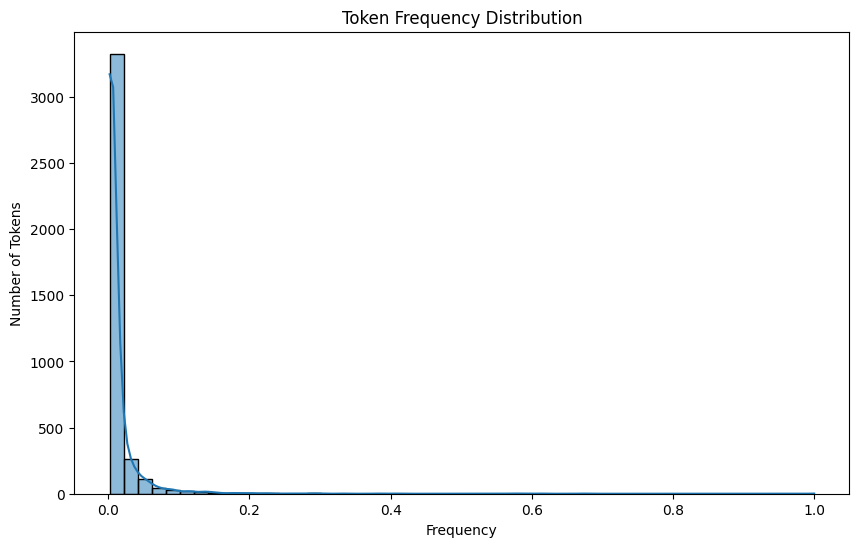

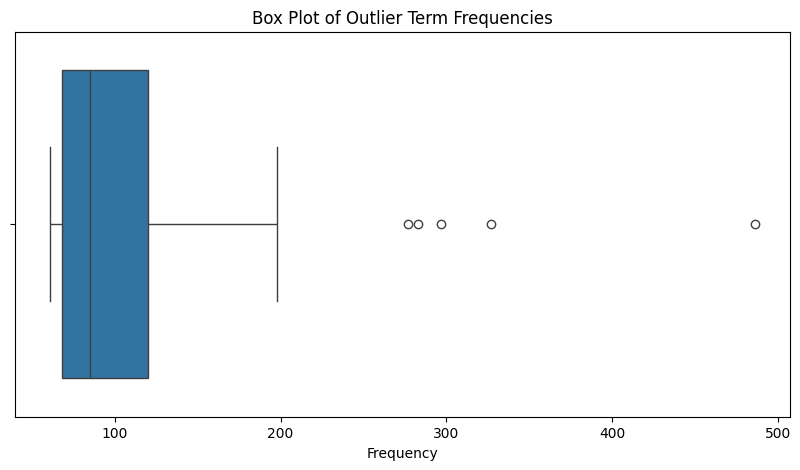

In [12]:
plt.figure(figsize=(10, 6))
sns.histplot(token_counts['Normalized_Frequency'], bins=50, kde=True)
plt.title('Token Frequency Distribution')
plt.xlabel('Frequency')
plt.ylabel('Number of Tokens')
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(x=outliers['Frequency'])
plt.title("Box Plot of Outlier Term Frequencies")
plt.xlabel("Frequency")
plt.show()

Now we take annotations from the dataset and train our bert model

In [14]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertForTokenClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split



tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")


class TermExtractionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            is_split_into_words=True,
            return_tensors="pt"
        )

        word_ids = encoding.word_ids()
        aligned_labels = []
        last_word = None

        for word in word_ids:
            if word is None:
                aligned_labels.append(-100)
            elif word != last_word:
                aligned_labels.append(self.labels[idx][word])
            else:
                aligned_labels.append(self.labels[idx][word])
            last_word = word

        aligned_labels = aligned_labels[:self.max_len] + [-100] * (self.max_len - len(aligned_labels))
        encoding["labels"] = torch.tensor(aligned_labels, dtype=torch.long)

        return {key: val.squeeze(0) for key, val in encoding.items()}


def load_data(tsv_files):
    texts, labels = [], []
    label_map = {"O": 0, "B": 1, "I": 2}

    for file in tsv_files:
        df = pd.read_csv(file, sep="\t", header=None, names=["Token", "Label"], quoting=3)
        text = df["Token"].tolist()
        label = [label_map[l] for l in df["Label"].tolist()]
        texts.append(text)
        labels.append(label)

    return texts, labels


tsv_files = ["corp_en_01_seq_terms.tsv",
            "corp_en_02_seq_terms.tsv",
            "corp_en_04_seq_terms.tsv",
            "corp_en_05_seq_terms.tsv",
            "corp_en_06_seq_terms.tsv",
            "corp_en_07_seq_terms.tsv",
            "corp_en_08_seq_terms.tsv",
            "corp_en_09_seq_terms.tsv",
            "corp_en_10_seq_terms.tsv",
            "corp_en_11_seq_terms.tsv",
            "corp_en_12_seq_terms.tsv",
            "corp_en_19_seq_terms.tsv"
]
texts, labels = load_data(tsv_files)
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [15]:
import os
os.environ["WANDB_DISABLED"] = "true"
train_dataset = TermExtractionDataset(train_texts, train_labels, tokenizer)
val_dataset = TermExtractionDataset(val_texts, val_labels, tokenizer)


model = BertForTokenClassification.from_pretrained("bert-base-uncased", num_labels=3)


training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)


trainer.train()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss
1,No log,0.407371
2,No log,0.267876
3,No log,0.237041


TrainOutput(global_step=6, training_loss=0.4929981231689453, metrics={'train_runtime': 92.9937, 'train_samples_per_second': 0.29, 'train_steps_per_second': 0.065, 'total_flos': 1763769053952.0, 'train_loss': 0.4929981231689453, 'epoch': 3.0})

In [16]:
from sklearn.metrics import precision_recall_fscore_support, classification_report
import numpy as np


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)


all_preds, all_labels = [], []

model.eval()
with torch.no_grad():
    for batch in val_loader:

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)


        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)


        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


pred_labels = []
true_labels = []

for pred_seq, true_seq in zip(all_preds, all_labels):
    for pred, true in zip(pred_seq, true_seq):
        if true != -100:
            pred_labels.append(pred)
            true_labels.append(true)


precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average="weighted")

print("\nEvaluation Results:")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}\n")





Evaluation Results:
Precision: 0.8379
Recall:    0.9153
F1-score:  0.8749



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


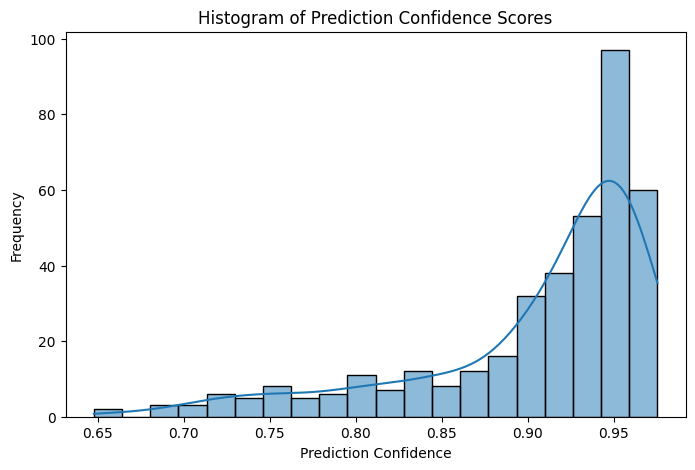

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F


probs = F.softmax(torch.tensor(trainer.predict(val_dataset).predictions), dim=-1)


confidences = probs.max(axis=-1).values.flatten().numpy()


plt.figure(figsize=(8, 5))
sns.histplot(confidences, bins=20, kde=True)
plt.xlabel("Prediction Confidence")
plt.ylabel("Frequency")
plt.title("Histogram of Prediction Confidence Scores")
plt.show()



In [20]:
import os
os.environ["WANDB_DISABLED"] = "true"
from transformers import RobertaTokenizerFast, RobertaForTokenClassification, Trainer, TrainingArguments,RobertaTokenizerFast
roberta_tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base", add_prefix_space=True)
train_dataset_roberta = TermExtractionDataset(train_texts, train_labels, roberta_tokenizer)
val_dataset_roberta = TermExtractionDataset(val_texts, val_labels, roberta_tokenizer)
roberta_model = RobertaForTokenClassification.from_pretrained("roberta-base", num_labels=3)


training_args_roberta = TrainingArguments(
    output_dir="./results_roberta",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs_roberta",
)


roberta_trainer = Trainer(
    model=roberta_model,
    args=training_args_roberta,
    train_dataset=train_dataset_roberta,
    eval_dataset=val_dataset_roberta,
)


roberta_trainer.train()


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss
1,No log,0.405426
2,No log,0.271354
3,No log,0.249329


TrainOutput(global_step=6, training_loss=0.5229361454645792, metrics={'train_runtime': 133.1112, 'train_samples_per_second': 0.203, 'train_steps_per_second': 0.045, 'total_flos': 1763769053952.0, 'train_loss': 0.5229361454645792, 'epoch': 3.0})

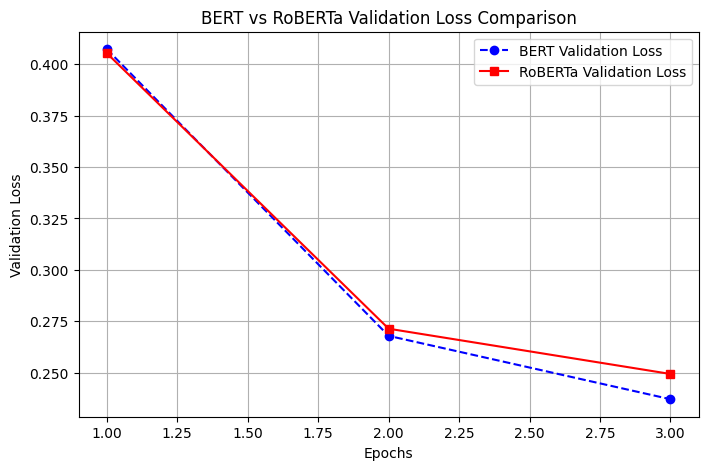

In [21]:
bert_val_losses = [log["eval_loss"] for log in trainer.state.log_history if "eval_loss" in log]
roberta_val_losses = [log["eval_loss"] for log in roberta_trainer.state.log_history if "eval_loss" in log]


epochs = list(range(1, len(bert_val_losses) + 1))  # Assuming both models have the same epoch count

plt.figure(figsize=(8, 5))
plt.plot(epochs, bert_val_losses, marker="o", label="BERT Validation Loss", linestyle="--", color="blue")
plt.plot(epochs, roberta_val_losses, marker="s", label="RoBERTa Validation Loss", linestyle="-", color="red")

plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.title("BERT vs RoBERTa Validation Loss Comparison")
plt.legend()
plt.grid()
plt.show()
